<a href="https://colab.research.google.com/github/nunocalaim/CA_MNIST/blob/main/20201111_NC_MNIST_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D

import json

In [16]:
CHANNEL_N = 19 # Number of CA state channels. It includes the 10 possible outputs but not the greyscale channel
PER_FILTERS = 80 # Number of filters to perception
CLASS_FILTERS = 80 # Number of filters of classifier (can this be diff than PER_FILTERS?)

TR_EVOLVE = 20 # Number of time steps to let CA evolve for each input
BATCH_SIZE = 16 # number of images per batch
BATCH_SIZE = 1 # number of images per batch


TR_NO_ITERATIONS = 100000 # number of iterations for the training loop
TR_NO_ITERATIONS = 1 # number of iterations for the training loop

ADD_NOISE = True # if True then the normal update of the CA has noise added
LIVING_THRESHOLD = 0.1 # the grayscale normalised minimum value for which to consider a CA alive
FR_THRESHOLD = 0.5 # update only this valyue % of ... actually I don't understad this

In [17]:
class CAModel(tf.keras.Model):
    
    def __init__(self, channel_n=CHANNEL_N, add_noise=ADD_NOISE):
        super().__init__()
        self.channel_n = channel_n
        self.add_noise = add_noise

        self.perceive = tf.keras.Sequential([
            Conv2D(PER_FILTERS, 3, activation=tf.nn.relu, padding="SAME"),
        ]) # I still don't fully understand what this does. I guess this takes state x of CA and augments it through a conv layer

        self.dmodel = tf.keras.Sequential([
            Conv2D(CLASS_FILTERS, 1, activation=tf.nn.relu),
            Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer),
        ])
        
        self(tf.zeros([1, 3, 3, channel_n + 1])) # dummy call to build the model
    
    @tf.function
    def call(self, x):
        '''
        this function updates the CA for one cycle
        x is the current CA state. its shape is (batch_size, height, width, no_channels). 
            batch_size is BATCH_SIZE.
            height and width are 28.
            no_channels is 1 + CHANNEL_N, 
                where the first is the gray image, 
                the last 10 are the classification predictions,
                and the others are there just for fun :)
        '''
        ds = self.dmodel(self.perceive(x)) # ds will be the state update (of course, we don't want to update the gray image as that is our true input)
        gray, state = tf.split(x, [1, self.channel_n], -1)
        if self.add_noise:
            residual_noise = tf.random.normal(tf.shape(ds), mean=0., stddev=0.02)
            ds += residual_noise

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= FR_THRESHOLD # I guess this is size (batch, h, w, 1)
        living_mask = gray > LIVING_THRESHOLD # I guess this is size (batch, h, w, 1)
        residual_mask = update_mask & living_mask # I guess this is size (batch, h, w, 1)
        ds *= tf.cast(residual_mask, tf.float32) 
        state += ds

        return tf.concat([gray, state], -1)

    @tf.function
    def initialize(self, images):
        '''
        input: images of size (batch, h, w)
        output: initial CA state full of 0's for positions other than the images. shape (batch, h, w, 1 + channel_n)
        '''
        state = tf.zeros([tf.shape(images)[0], 28, 28, self.channel_n]) # size (batch, h, w, channel_n) full of zeros
        images = tf.reshape(images, [-1, 28, 28, 1]) # our images we add an extra dimension
        return tf.concat([images, state], -1) # just concatenating

    @tf.function
    def classify(self, x):
        '''
        The last 10 layers are the classification predictions, one channel
        per class. Keep in mind there is no "background" class,
        and that any loss doesn't propagate to "dead" pixels.
        '''
        return x[:, :, :, -10:]

CAModel().perceive.summary()
CAModel().dmodel.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (1, 3, 3, 80)             14480     
Total params: 14,480
Trainable params: 14,480
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (1, 3, 3, 80)             6480      
_________________________________________________________________
conv2d_17 (Conv2D)           (1, 3, 3, 19)             1539      
Total params: 8,019
Trainable params: 8,019
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Training utilities

def individual_l2_loss(x, y):
    '''
    x is the current CA state vector. its shape is (batch_size, height, width, no_channels).
    y is the correct label out of 10 possibilities. its shape is (batch_size, height, width, 10) (one-hot)
    '''
    t = y - ca.classify(x) # basically we want 1's for the correct and 0s for the incorrect digit. its shape is (batch_size, height, width, 10) (one-hot)
    return tf.reduce_sum(t ** 2, [1, 2, 3]) / 2 # size batch_size

def batch_l2_loss(x, y):
    '''
    x is the current CA state vector. its shape is (batch_size, height, width, no_channels).
    y is the correct label out of 10 possibilities. its shape is (batch_size, height, width, 10) (one-hot)
    returns the mean of the loss function
    '''
    return tf.reduce_mean(individual_l2_loss(x, y))

lr = 1e-3 # initial learning rate
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([int(TR_NO_ITERATIONS*0.3), int(TR_NO_ITERATIONS*0.7)], [lr, lr*0.1, lr*0.01])
trainer = tf.keras.optimizers.Adam(lr_sched) # use ADAM optimizer with learning rate schedule

loss_log = [] # for plotting of loss function across time

def export_model(ca, base_fn):
    '''
    Saves the models parameters in file name base_fn
    '''
    ca.save_weights(base_fn)

    cf = ca.call.get_concrete_function(x = tf.TensorSpec([None, None, None, CHANNEL_N+1]))
    cf = convert_to_constants.convert_variables_to_constants_v2(cf)
    graph_def = cf.graph.as_graph_def()
    graph_json = MessageToDict(graph_def)
    graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
    model_json = {
        'format': 'graph-model',
        'modelTopology': graph_json,
        'weightsManifest': [],
    }
    with open(base_fn+'.json', 'w') as f:
        json.dump(model_json, f)



In [28]:
# Prepare the dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.array(x_train / 255.0,).astype(np.float32)
x_test = np.array(x_test / 255.0,).astype(np.float32)


def to_ten_dim_label(x, y):
    '''
    input x shape is (no_images, height, width)
    input y shape is (no_images,)
    output: y_res (no_images, height, width, 10) y_res[b, h, w, i] = 1 if the image b is digit i, and only at the positions h, w where it is alive
    '''
    y_res = np.zeros(list(x.shape) + [10])
    y_expanded = np.broadcast_to(y, x.T.shape).T # broadcast y to match x shape:
    y_res[x >= LIVING_THRESHOLD, y_expanded[x >= LIVING_THRESHOLD]] = 1.0 #
    return y_res.astype(np.float32)

y_train_pic = to_ten_dim_label(x_train, y_train)
# y_test_pic = to_ten_dim_label(x_test, y_test)

In [27]:
a = np.random.randn(3, 4, 5)
b = np.random.randn(3)
print(a, b)
print(a, np.broadcast_to(b, a.T.shape).T)

[[[ 0.93922432  0.89638196 -1.68495572  0.1777811  -0.95294535]
  [ 0.64271998 -0.28456121 -0.84549924 -0.32952654  1.03997017]
  [ 0.73714633 -1.16163243 -1.27361551  0.66540782  0.09019051]
  [-0.47673642  0.97038622  0.06720716  0.89934849 -0.0528374 ]]

 [[ 0.57851741 -1.00147287 -0.92709125  0.52975749 -0.62648174]
  [ 1.38711651  1.11725873  1.7534531  -0.52021237 -0.54599451]
  [ 0.27252445  0.47543917 -0.61240874 -1.43600691 -0.73406249]
  [-0.3965438   1.0017944  -0.13928547  1.20781554 -0.41215007]]

 [[-0.00810756  0.23120565 -0.94430096  0.61229871  1.31281622]
  [ 1.16026577  1.19121688 -0.35750661 -0.11492323  0.16120102]
  [-0.22658267  0.51921208 -0.57271143 -1.18678104 -0.861365  ]
  [-1.53595642  2.07688166  0.23652964  0.87284657 -0.12296488]]] [1.75044833 1.26315116 0.14007051]
[[[ 0.93922432  0.89638196 -1.68495572  0.1777811  -0.95294535]
  [ 0.64271998 -0.28456121 -0.84549924 -0.32952654  1.03997017]
  [ 0.73714633 -1.16163243 -1.27361551  0.66540782  0.09019051]

NameError: ignored

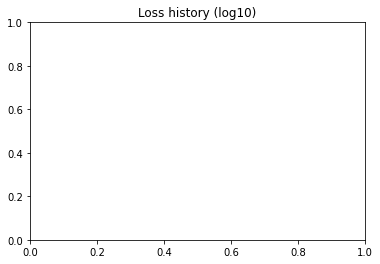

In [21]:
# Training happens here
ca = CAModel()
fig, ax = plt.subplots(1, 1);
ax.set_title('Loss history (log10)')

# Training Step
@tf.function
def train_step(x, y):
    '''
    x is the current CA state. its shape is (batch_size, height, width, no_channels).
    y is the correct label out of 10 possibilities. its shape is (batch_size, ?)
    '''
    iter_n = TR_EVOLVE # Number of iterations of the CA for each training step
    with tf.GradientTape() as g: # GradientTape does automatic differentiation on the learnable_parameters of our model
        for i in tf.range(iter_n): # Basically let time evolve
            x = ca(x) # update the CA according to call method? ca(x) = ca.call(x)?
        loss = batch_l2_loss(x, y) # compute the scalar loss
    grads = g.gradient(loss, ca.weights) # Gradient Tape and Keras doing its magic
    grads = [g/(tf.norm(g)+1e-8) for g in grads] # Normalising the gradients uh?
    trainer.apply_gradients(zip(grads, ca.weights)) # Keras and ADAM magic 
    return x, loss

# Training Loop
for i in range(TR_NO_ITERATIONS):
#   if USE_PATTERN_POOL:
#     batch = pool.sample(BATCH_SIZE)
#     x0 = np.copy(batch.x)
#     y0 = batch.y
#     # we want half of them new. We remove 1/4 from the top and 1/4 from the
#     # bottom.
#     q_bs = BATCH_SIZE // 4

#     new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
#     x0[:q_bs] = ca.initialize(x_train[new_idx])
#     y0[:q_bs] = y_train_pic[new_idx]

#     new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
#     new_x, new_y = x_train[new_idx], y_train_pic[new_idx]
#     if MUTATE_POOL:
#       new_x = tf.reshape(new_x, [q_bs, 28, 28, 1])
#       mutate_mask = tf.cast(new_x > 0.1, tf.float32)
#       mutated_x = tf.concat([new_x, x0[-q_bs:,:,:,1:] * mutate_mask], -1)

#       x0[-q_bs:] = mutated_x
#       y0[-q_bs:] = new_y

#     else:
#       x0[-q_bs:] = ca.initialize(new_x)
#       y0[-q_bs:] = new_y

#   else:
#     b_idx = np.random.randint(0, x_train.shape[0]-1, size=BATCH_SIZE)
#     x0 = ca.initialize(x_train[b_idx])
#     y0 = y_train_pic[b_idx]

    b_idx = np.random.randint(0, x_train.shape[0] - 1, size=BATCH_SIZE)
    x0 = ca.initialize(x_train[b_idx])
    y0 = y_train_pic[b_idx]

    x, loss = train_step(x0, y0)

#   if USE_PATTERN_POOL:
#     batch.x[:] = x
#     batch.y[:] = y0 # This gets reordered, so you need to change it.
#     batch.commit()

    loss_log[i] = loss.numpy()

#   if step_i%100 == 0:
#     generate_pool_figures(ca, pool, step_i)
    if i % 200 == 0:        
        ax.clear()
        ax.plot(np.log10(loss_log[:i]), '.', alpha=0.1)
        plt.show()

#     visualize_batch(ca, x0, x, step_i)
#     plot_loss(loss_log)
    if i % 10000 == 0:
        export_model(ca, 'train_log/%07d'%i)

    print('\r step: %d, log10(loss): %.3f'%(i + 1, np.log10(loss)), end='')